In [38]:
import numpy as np
from jesse import helpers, research

_, trading_1m = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(trading_1m.shape)

np.save("data/btc_1m.npy", trading_1m)

(2630880, 6)


In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
print(candles.shape)
candles[0, 0]


(2630880, 6)


1577836800000.0

In [2]:
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe

df = numpy_candles_to_dataframe(candles)

# label
df["label"] = np.log(df["close"].shift(-1) / df["close"])

# high low range
df["hlr"] = np.log(df["high"] / df["low"])
df["log_hlr"] = np.log(df["hlr"] + 1)
df["sqrt_hlr"] = np.sqrt(df["hlr"] + 1) - 1

# abs return
ret_list = []
for i in range(1, 150):
    ret_series = np.log(df["close"] / df["close"].shift(i))
    ret_series.name = f"r{i}"
    ret_list.append(ret_series)

df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list

# log return and sqrt return
log_sqrt_list = []
for i in range(1, 150):
    log_series = np.log(df[f"r{i}"] + 1)
    log_series.name = f"log_r{i}"
    log_sqrt_list.append(log_series)
    sqrt_series = np.sqrt(df[f"r{i}"] + 1) - 1
    sqrt_series.name = f"sqrt_r{i}"
    log_sqrt_list.append(sqrt_series)

df = pd.concat([df, pd.concat(log_sqrt_list, axis=1)], axis=1)
del log_sqrt_list

# data cleaning
df = df[df["r149"].notna()]
del candles
print(df.shape)

df.head()


(2630731, 457)


,date,open,close,high,low,volume,label,hlr,log_hlr,sqrt_hlr,...,log_r145,sqrt_r145,log_r146,sqrt_r146,log_r147,sqrt_r147,log_r148,sqrt_r148,log_r149,sqrt_r149
2020-01-01 02:29:00,2020-01-01 02:29:00,7233.19,7228.09,7233.57,7225.76,7.972429,0.000664,0.001080,0.001080,0.000540,...,0.006684,0.003347,0.005831,0.002920,0.006317,0.003164,0.006096,0.003052,0.005729,0.002869
2020-01-01 02:30:00,2020-01-01 02:30:00,7227.12,7232.89,7233.14,7226.79,4.631254,-0.000192,0.000878,0.000878,0.000439,...,0.007314,0.003664,0.007343,0.003678,0.006491,0.003251,0.006977,0.003494,0.006755,0.003383
2020-01-01 02:31:00,2020-01-01 02:31:00,7232.35,7231.50,7233.84,7229.47,13.106277,0.000176,0.000604,0.000604,0.000302,...,0.006845,0.003428,0.007123,0.003568,0.007152,0.003582,0.006300,0.003155,0.006786,0.003399
2020-01-01 02:32:00,2020-01-01 02:32:00,7231.69,7232.77,7233.14,7229.78,18.132154,-0.000151,0.000465,0.000465,0.000232,...,0.006790,0.003401,0.007019,0.003516,0.007297,0.003655,0.007326,0.003670,0.006475,0.003243
2020-01-01 02:33:00,2020-01-01 02:33:00,7232.06,7231.68,7236.07,7230.19,10.299170,0.000426,0.000813,0.000813,0.000406,...,0.006084,0.003047,0.006640,0.003326,0.006870,0.003441,0.007148,0.003580,0.007177,0.003595


In [3]:
data_check = np.load("data/btc_1m.npy")
# hlr_check = np.abs(np.log(data_check[:, 3] / data_check[:, 4]))
# r1_check = np.abs(np.log(data_check[1:, 2] / data_check[:-1, 2]))

data_check = data_check[149:]
# hlr_check = hlr_check[149:]
# r1_check = r1_check[149 - 1 :]

# data_check = data_check[(hlr_check > 0) & (r1_check > 0)]

assert data_check.shape[0] == df.shape[0]

In [34]:
# from custom_indicators.utils.plot import find_kde_cross

# target = np.log(df["close"] / df["close"].shift(149)).dropna()
# roots = find_kde_cross(target)


In [35]:
# label = (df["abs_r1p149"] >= 1.026490246399058236).astype(int)
# label.name = "label"
# label.sort_index(inplace=True)
# label.value_counts()

In [9]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from scipy import stats

from custom_indicators.toolbox.bar.build import (
    build_bar_by_threshold_greater_than,
    build_bar_by_threshold_less_than,
)


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    MIN_LENGTH = 1500

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")
    # h1r = np.abs(np.log(candles_in_metrics[:, 3] / candles_in_metrics[:, 4]))
    # r1 = np.abs(np.log(candles_in_metrics[1:, 2] / candles_in_metrics[:-1, 2]))
    candles_in_metrics = candles_in_metrics[149:]
    # h1r = h1r[149:]
    # r1 = r1[149 - 1 :]
    # candles_in_metrics = candles_in_metrics[(h1r > 0) & (r1 > 0)]
    candles_in_metrics = candles_in_metrics[:-1]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )
    # sigmoid y_pred
    y_pred = 1 / (1 + np.exp(-y_pred))

    if all(y_pred > 0.5) or all(y_pred < 0.5):
        return 1000

    merged_bar_1 = build_bar_by_threshold_greater_than(
        candles_in_metrics,
        y_pred,
        0.5,
        reverse=False,
    )

    merged_bar_2 = build_bar_by_threshold_less_than(
        candles_in_metrics,
        y_pred,
        0.5,
        reverse=True,
    )

    if len(merged_bar_1) < MIN_LENGTH and len(merged_bar_2) < MIN_LENGTH:
        return 1000
    elif len(merged_bar_1) < MIN_LENGTH:
        log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
        std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
        kurtosis_2 = stats.kurtosis(std_log_ret_2)
        return kurtosis_2
    elif len(merged_bar_2) < MIN_LENGTH:
        log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
        std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
        kurtosis_1 = stats.kurtosis(std_log_ret_1)
        return kurtosis_1
    else:
        log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
        std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
        kurtosis_1 = stats.kurtosis(std_log_ret_1)
        log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
        std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
        kurtosis_2 = stats.kurtosis(std_log_ret_2)
        return min(kurtosis_1, kurtosis_2)


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = (
    ["hlr", "log_hlr", "sqrt_hlr"]
    + [f"r{i}" for i in range(1, 150)]
    + [f"log_r{i}" for i in range(1, 150)]
    + [f"sqrt_r{i}" for i in range(1, 150)]
)

est_gp = SymbolicRegressor(
    init_method="full",
    metric=custom_kurtosis_loss,
    population_size=10000,
    generations=30,
    tournament_size=50,
    stopping_criteria=0,
    function_set=["add", "sub", "abs", "neg", "max", "min"],
    p_crossover=0.7,
    p_subtree_mutation=0.12,
    p_hoist_mutation=0.06,
    p_point_mutation=0.12,
    max_samples=1,
    parsimony_coefficient=0.009,
    feature_names=cols,
    verbose=1,
    n_jobs=10,
    # random_state=233,
)

label = df["label"]

est_gp.fit(df[cols].iloc[:-1], label.iloc[:-1])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    22.97           310.48       45          21.7911              N/A    195.86m
   1    38.16           179.67       31          17.3109              N/A    161.73m
   2    45.92          111.545       51          14.4099              N/A    162.99m
   3    43.05          113.506       45          13.3245              N/A    152.06m
   4    45.32          107.746       49          10.7568              N/A    147.46m
   5    50.67          110.503       49          10.7568              N/A    148.19m
   6    53.88          108.693       93          10.0511              N/A    145.54m
   7    67.10          98.4401       68          9.85811              N/A    152.74m
   8    69.73          93.0406       63          9.67726              N/A  

SymbolicRegressor(feature_names=['hlr', 'log_hlr', 'sqrt_hlr', 'r1', 'r2', 'r3',
                                 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10',
                                 'r11', 'r12', 'r13', 'r14', 'r15', 'r16',
                                 'r17', 'r18', 'r19', 'r20', 'r21', 'r22',
                                 'r23', 'r24', 'r25', 'r26', 'r27', ...],
                  function_set=['add', 'sub', 'abs', 'neg', 'max', 'min'],
                  generations=30, init_method='full', max_samples=1,
                  metric=<gplearn.fitness._Fitness object at 0x17a629a10>,
                  n_jobs=10, p_crossover=0.7, p_hoist_mutation=0.06,
                  p_point_mutation=0.12, p_subtree_mutation=0.12,
                  parsimony_coefficient=0.009, population_size=10000,
                  stopping_criteria=0, tournament_size=50, verbose=1)

In [12]:
import pandas as pd

fitness_list = []
program_len_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 10:
            fitness_list.append(program.fitness_)
            program_len_list.append(len(str(program)))
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "len": program_len_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by=["fitness"], inplace=True)
df_res.head(10)


,fitness,len,program
4341,7.979818,382,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
4467,8.015818,406,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
4338,8.063222,403,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
2271,8.072222,412,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
3305,8.081222,417,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
4614,8.090222,422,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
2341,8.099222,431,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
4014,8.099222,427,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
2160,8.099222,427,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."
3576,8.099222,430,"neg(add(max(neg(min(min(log_r1, r52), neg(log_..."


In [13]:
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")


fitness = 7.9798176884283905: neg(add(max(neg(min(min(log_r1, r52), neg(log_r123))), sub(max(max(max(abs(sqrt_r76), sqrt_r91), abs(log_r16)), neg(max(r125, r47))), sub(max(r133, log_r28), abs(r64)))), abs(sub(neg(add(log_r37, r142)), neg(add(min(add(log_r95, max(r44, r30)), min(log_r96, min(r75, neg(max(sub(r60, log_r1), abs(max(sqrt_r95, r47))))))), sub(sub(log_r122, log_r95), max(log_r106, sqrt_r140))))))))
fitness = 8.01581768842839: neg(add(max(neg(min(min(log_r1, r52), neg(log_r123))), sub(max(max(max(abs(sqrt_r76), sqrt_r91), neg(max(r125, r47))), abs(log_r16)), sub(max(r133, log_r28), abs(r64)))), abs(sub(neg(add(log_r37, r142)), neg(add(min(add(log_r95, max(r44, r30)), min(log_r96, min(r75, min(r75, min(log_r96, neg(max(sub(r60, log_r1), abs(max(sqrt_r95, r47))))))))), sub(sub(log_r122, log_r95), max(log_r106, sqrt_r140))))))))
fitness = 8.06322235377133: neg(add(max(neg(min(min(log_r1, r52), neg(log_r123))), sub(max(max(sub(neg(max(sqrt_r132, log_r123)), abs(neg(r22))), neg(ma

In [8]:
"""
abs(sqrt(abs_r146 - sqrt(abs_r4))) - abs_r27
"""
from math import sqrt

import numpy as np
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe

_, candles = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2025-01-01"),
    helpers.date_to_timestamp("2025-05-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(candles.shape)

# hlr_check = np.abs(np.log(candles[:, 3] / candles[:, 4]))[1:]
# r1_check = np.abs(np.log(candles[1:, 2] / candles[:-1, 2]))
# candles = candles[1:]

# candles = candles[(hlr_check > 0) & (r1_check > 0)]

df = numpy_candles_to_dataframe(candles)
for i in [4, 27, 146]:
    df[f"r{i}"] = np.abs(np.log(df["close"] / df["close"].shift(i)))


df = df[df["r146"].notna()]
print(df.shape)


def get_gp_res(abs_r4, abs_r27, abs_r146):
    try:
        res = abs(sqrt(max(abs_r146 - sqrt(abs_r4), 1e-8))) - abs_r27
        return res
    except Exception as e:
        print(f"{abs_r4 = }, {abs_r27 = }, {abs_r146 = }")
        raise e


res_list = []
for abs_r4, abs_r27, abs_r146 in zip(df["abs_r4"], df["abs_r27"], df["abs_r146"]):
    res = get_gp_res(abs_r4, abs_r27, abs_r146)
    res = 1 / (1 + np.exp(-res))
    res_list.append(res)

df["res"] = res_list

df.head()

(172800, 6)
(169417, 9)


,date,open,close,high,low,volume,abs_r4,abs_r27,abs_r146,res
2025-01-01 02:33:00,2025-01-01 02:33:00,93787.70,93765.14,93787.71,93765.13,1.48471,0.000241,0.000122,0.001207,0.499994
2025-01-01 02:34:00,2025-01-01 02:34:00,93765.14,93773.61,93773.61,93765.13,6.30471,0.000274,0.000218,0.000762,0.499971
2025-01-01 02:35:00,2025-01-01 02:35:00,93773.61,93804.00,93804.00,93773.60,1.81904,0.000275,0.000523,0.001344,0.499894
2025-01-01 02:36:00,2025-01-01 02:36:00,93804.00,93804.37,93804.38,93803.99,1.22463,0.000178,0.000984,0.001527,0.499779
2025-01-01 02:37:00,2025-01-01 02:37:00,93804.38,93821.74,93821.74,93804.37,2.58019,0.000603,0.001544,0.001533,0.499639


In [9]:
candles.shape[0] - df.shape[0]

146

In [10]:
(df["res"] > 0.5).astype(int).value_counts()

res
0    157806
1     11611
Name: count, dtype: int64

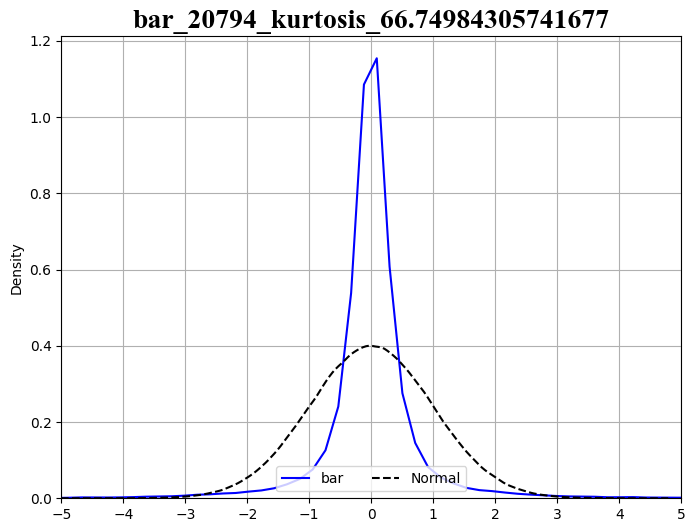

In [12]:
from custom_indicators.utils.plot import plot_kde

merged_bar = build_bar_by_threshold_greater_than(
    candles[146:], df["res"].tolist(), 0.5, reverse=False
)

plot_kde(merged_bar[:, 2])

In [51]:
from jesse.utils import numpy_candles_to_dataframe
from lightweight_charts import Chart

df_merged_bar = numpy_candles_to_dataframe(merged_bar)
df_merged_bar.head()

chart = Chart()
chart.set(df_merged_bar[["date", "open", "high", "low", "close", "volume"]])
chart.show(block=True)


RuntimeError: asyncio.run() cannot be called from a running event loop